In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import ast
import numpy as np

LABELS = ['emp', 'mus', 'rara', 'ory', 'fsi', 'lyn', 'lut', 'sus', 'mel', 'vul', 'lep', 'equ', 'cer', 'bos', 'gen', 'her', 'dam', 'fel', 'can', 'ovar', 'mafo', 'capi', 'caae', 'ovor', 'caca']

In [2]:
def parse_results(model):
    with open(f"{model}_metrics.txt", "r") as f:
        results = {
            "precision": float(f.readline().split(" ")[1]),
            "recall": float(f.readline().split(" ")[1]),
            "f1": float(f.readline().split(" ")[1]),
            "iou": float(f.readline().split(" ")[1]),
            "matrix": []
        }

        f.readline()
        while line := f.readline():
            if line.strip() == "": break
            results["matrix"].append(list(map(int, line.split(" "))))
    return results

models = {
    "YOLO": parse_results("yolo"),
    "FasterRCNN": parse_results("fasterrcnn"),
    "Megadetector": parse_results("megadetector")
}

# Plotting

In [3]:
# Compare the model's precision, recall, f1, and iou

results = pd.DataFrame({
    "model": [],
    "precision": [],
    "recall": [],
    "f1": [],
    "iou": []
})
for model in models.keys():
    results = pd.concat([results, pd.DataFrame({
        "model": [model],
        "precision": [models[model]["precision"]],
        "recall": [models[model]["recall"]],
        "f1": [models[model]["f1"]],
        "iou": [models[model]["iou"]]
    })], ignore_index=True)
metrics_tables = {metric: group.drop(columns="metric") for metric, group in results.melt(id_vars=["model"], var_name="metric", value_name="value").groupby("metric")}
metrics_tables

{'f1':           model     value
 6          YOLO  0.926799
 7    FasterRCNN  0.770453
 8  Megadetector  0.890131,
 'iou':            model     value
 9           YOLO  0.951850
 10    FasterRCNN  0.847787
 11  Megadetector  0.945879,
 'precision':           model     value
 0          YOLO  0.934396
 1    FasterRCNN  0.778151
 2  Megadetector  0.906661,
 'recall':           model     value
 3          YOLO  0.925050
 4    FasterRCNN  0.768724
 5  Megadetector  0.892421}

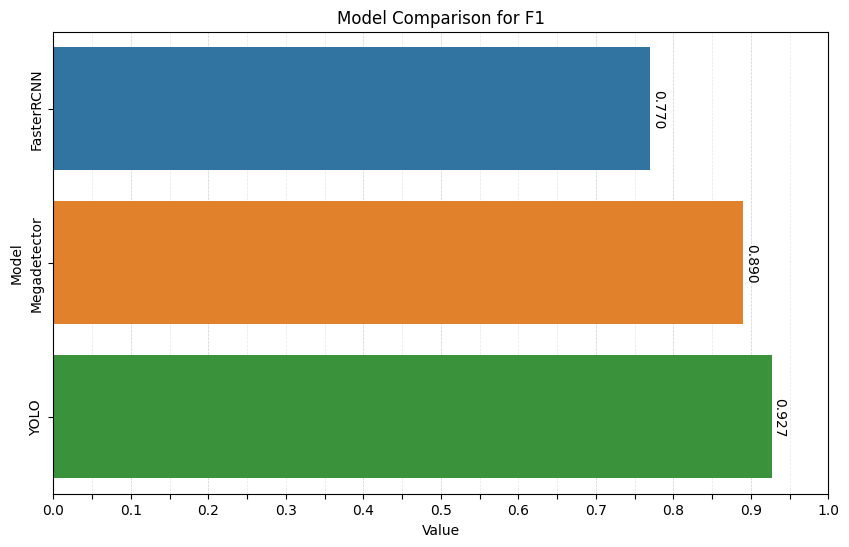

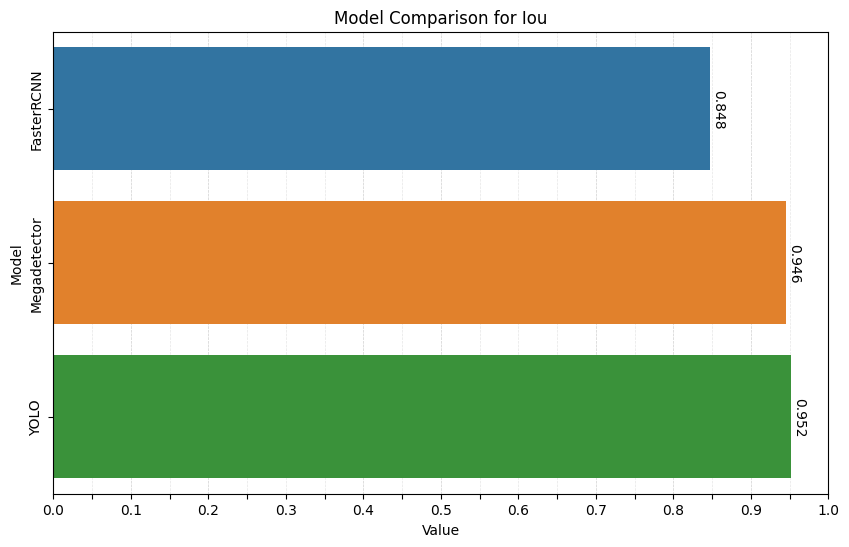

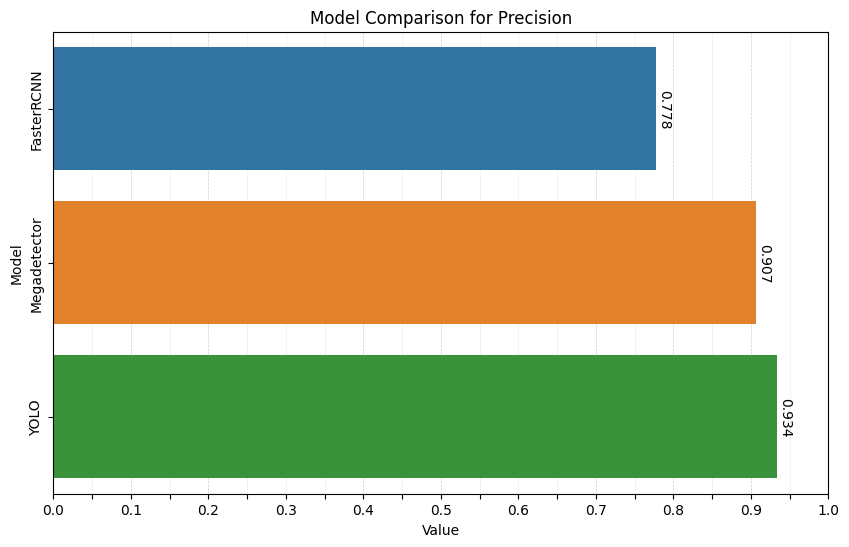

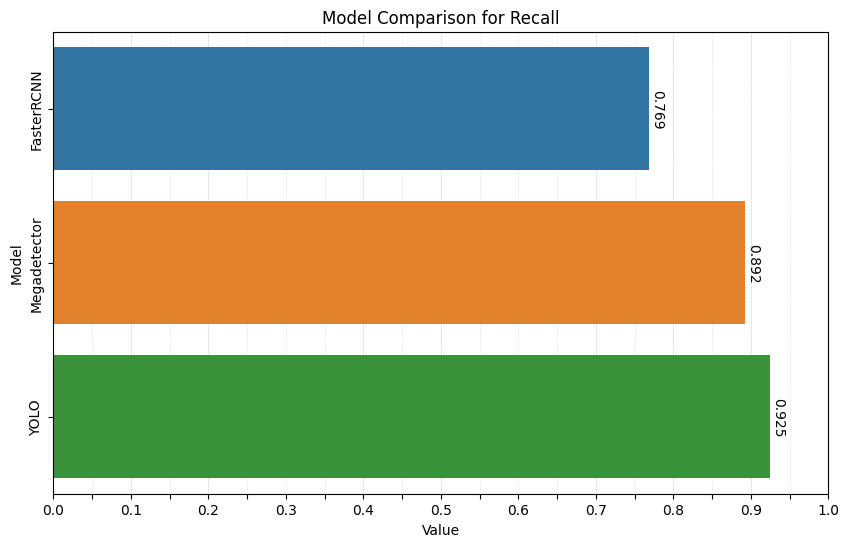

In [5]:
def get_metric_plot(table, metric):
    table = table.sort_values(by="value", ascending=True)
    plt.figure(figsize=(10, 6))
    sns.barplot(x="value", y="model", hue="model", data=table)
    plt.xlim(0.0, 1)
    plt.xlabel("Value")
    plt.xticks(ticks=[i * 0.05 for i in range(21)], labels=[f"{i * 0.05:.1f}" if i % 2 == 0 else "" for i in range(21)])
    plt.ylabel("Model")
    # Add exact value at the end of each bar
    for bar in plt.gca().patches:
        bar_index = bar.get_y() + bar.get_height() / 2
        plt.text(bar.get_width() + 0.01, bar_index, f'{bar.get_width():.3f}', va='center', ha='center', rotation=270)
            
    # Add vertical lines for better visualization
    for value in table["value"]:
        for tick in plt.xticks()[0]:
            if tick*100 % 2: plt.axvline(x=tick, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.2, zorder=0)
            else: plt.axvline(x=tick, color='lightgray', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)

    plt.yticks(rotation=90, va="center")
    plt.title(f"Model Comparison for {metric.capitalize()}")
    return plt

for metric, table in metrics_tables.items():
    get_metric_plot(table, metric).show()

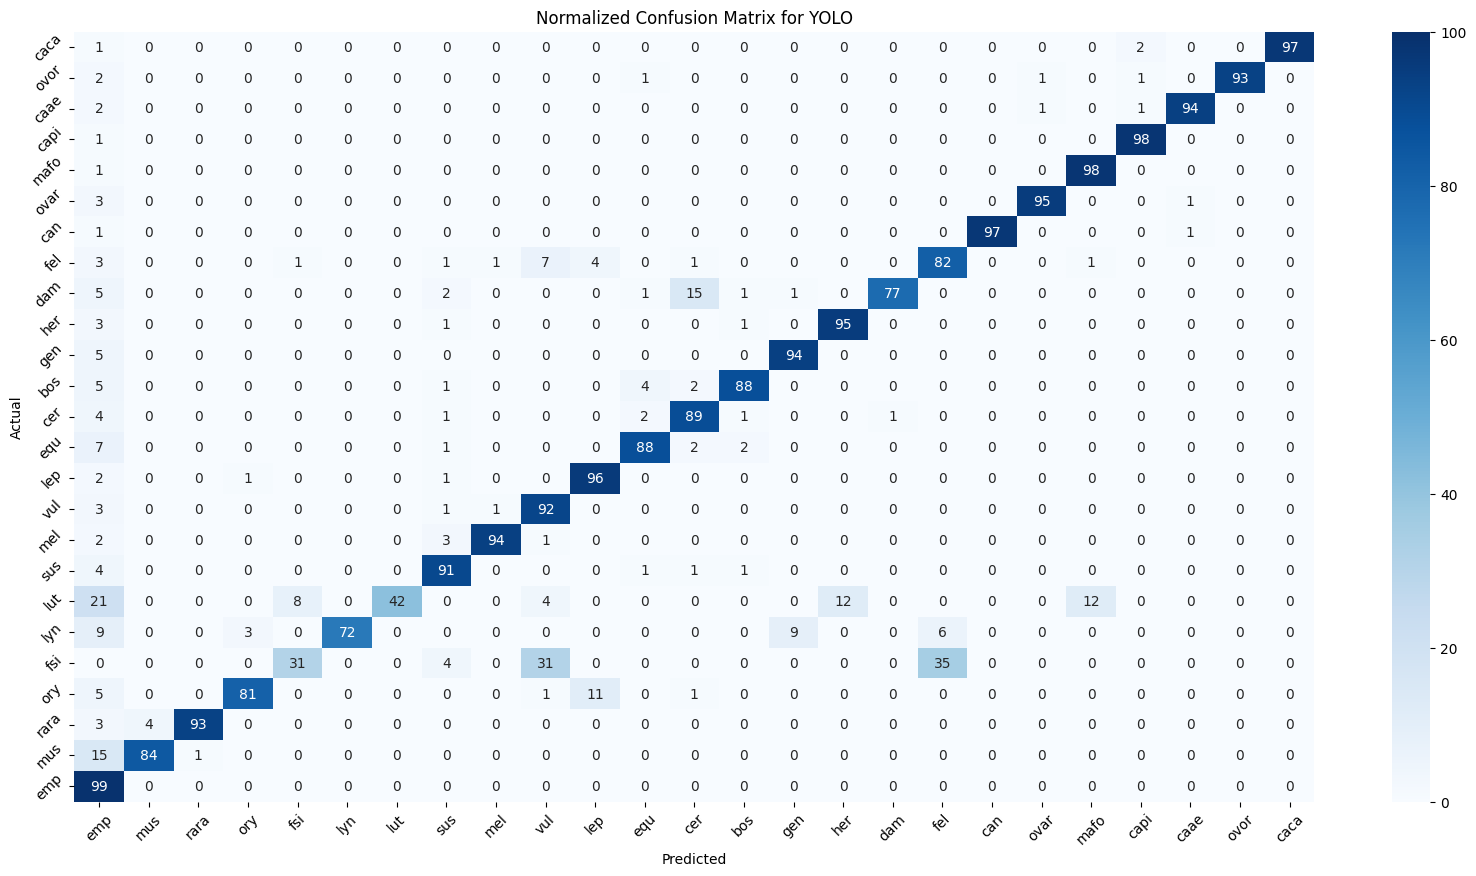

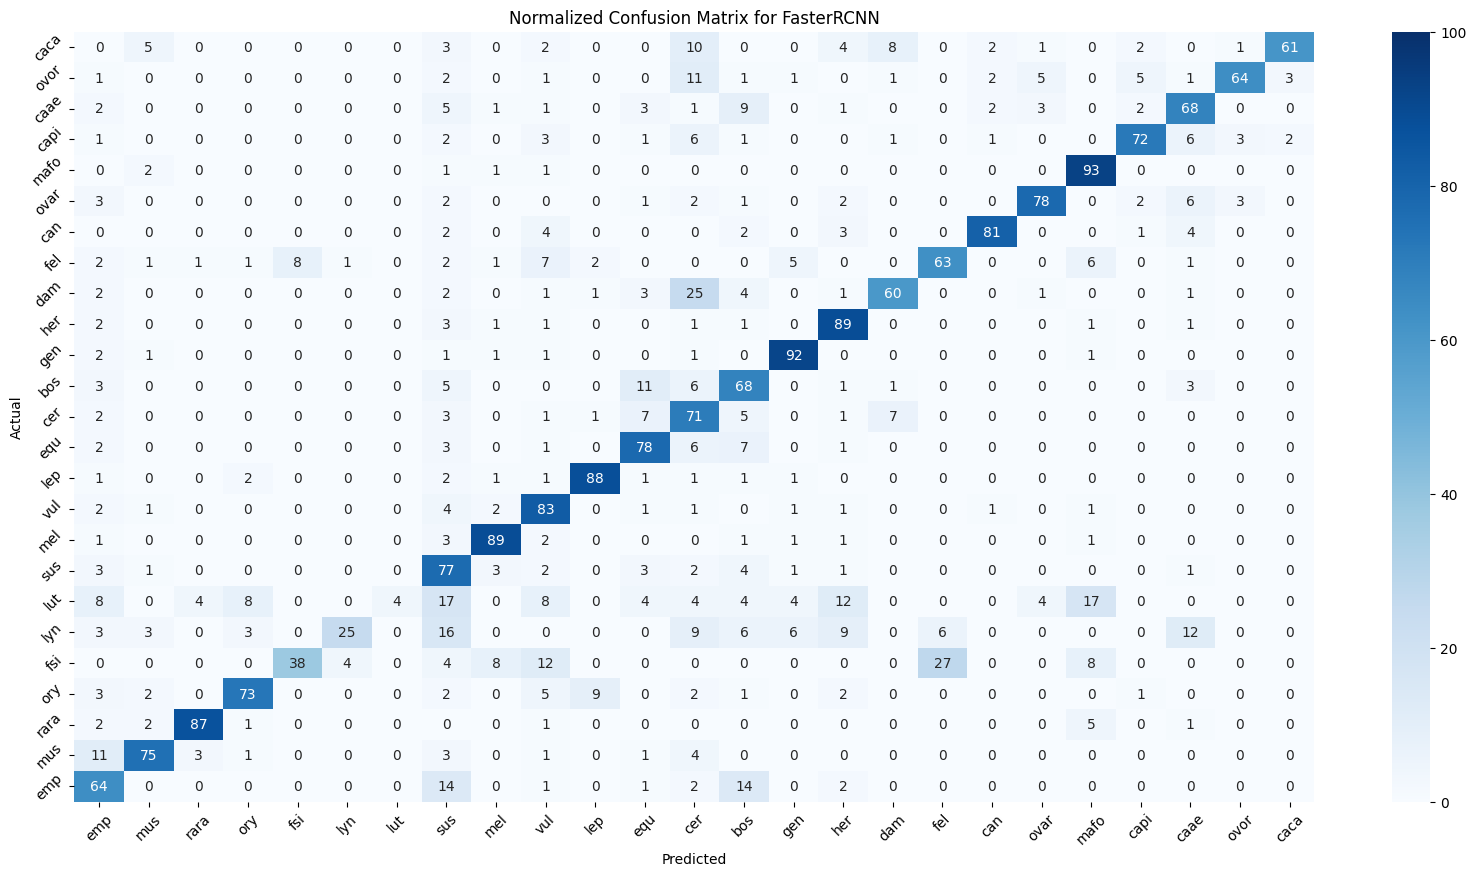

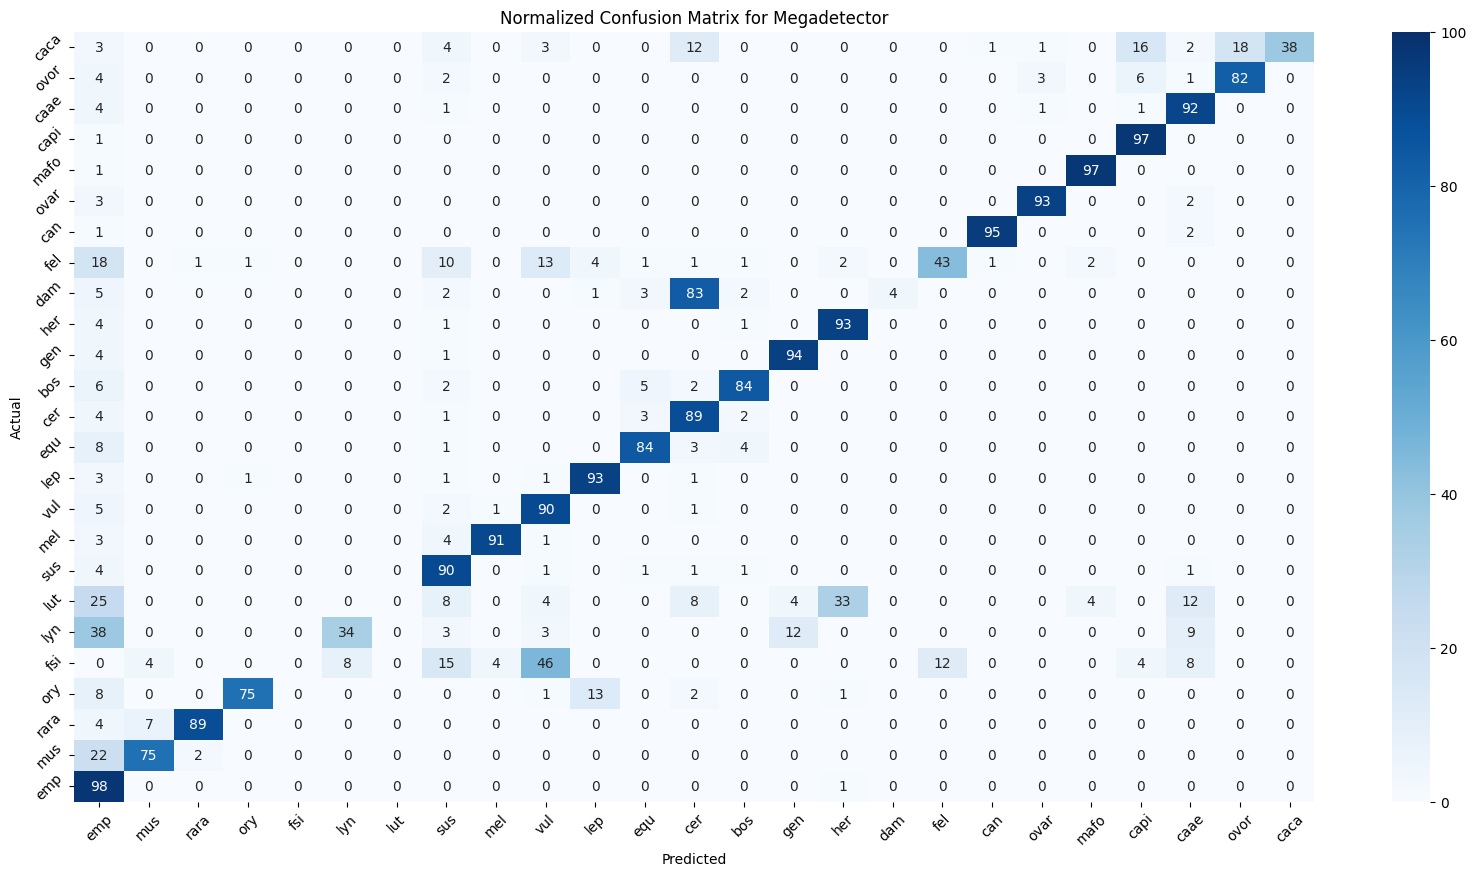

In [8]:
# Normalize and show the confusion matrix for each model
def plot_confusion_matrix(matrix, model):
    matrix = round(matrix.div(matrix.sum(axis=1), axis=0).iloc[::-1] * 100)
    plt.figure(figsize=(20, 10))
    sns.heatmap(matrix, annot=True, fmt='g', vmin=0, vmax=100, cmap='Blues')

    # Set tick labels and axis labels
    step_values = [i for i in range(len(LABELS))]
    plt.xticks(ticks=[i + 0.5 for i in step_values], labels=LABELS, rotation=45)
    plt.yticks(ticks=[i + 0.5 for i in step_values[::-1]], labels=LABELS, rotation=45)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Normalized Confusion Matrix for {model}")
    return plt

for model in models.keys():
    matrix = pd.DataFrame(models[model]["matrix"])
    plot_confusion_matrix(matrix, model).show()

In [10]:
# Import a model's values and do more sklearn metrics.
def read_values(file_path):
    true_values = []
    pred_values = []
    iou_values = []

    # Open the file and read its content
    with open(file_path, 'r') as file:
        for line in file:
            # Check for each line and parse the values
            if line.startswith('True vals:'):
                true_values = ast.literal_eval(line.split(':')[1].strip())  # safely evaluate the list
            elif line.startswith('Pred vals:'):
                pred_values = ast.literal_eval(line.split(':')[1].strip())  # safely evaluate the list
            elif line.startswith('IoU vals:'):
                iou_values = ast.literal_eval(line.split(':')[1].strip())  # safely evaluate the list

    return true_values, pred_values, iou_values

In [11]:
def calculate_mAP(true, pred, iou, iou_threshold=0.5):
    # Step 1: Initialize counters for true positives, false positives, and false negatives
    true_positives = defaultdict(int)
    false_positives = defaultdict(int)
    false_negatives = defaultdict(int)
    
    # Step 2: Iterate through the true, pred, and iou lists
    idx = 0  # Index counter for valid true/pred
    for t, p in zip(true, pred):
        if t != -1 and p != -1:  # Only consider valid cases
            i = iou[idx]  # Get the IoU value for the current pair
            if i >= iou_threshold:
                true_positives[p] += 1
            else:
                false_positives[p] += 1
                false_negatives[t] += 1
            idx += 1  # Increment the index only for valid cases

    # Step 3: Calculate Precision, Recall, and AP for each class
    APs = {}
    for clas in set(true + pred):
        tp = true_positives[clas]
        fp = false_positives[clas]
        fn = false_negatives[clas]
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # For simplicity, AP is just precision in this basic version (you could interpolate for full PR curve)
        APs[clas] = precision

    # Step 4: Calculate mAP (mean of all APs)
    mAP = np.mean(list(APs.values()))
    return mAP, APs

In [26]:
model_mAP = {}
for model in ['yolo', 'megadetector', 'fasterrcnn']:
    true, pred, iou = read_values(f"{model}_values.txt")
    model_mAP[model] = {}
    for i in range(50, 100, 5):
        f = i/100
        mAP, APs = calculate_mAP(true, pred, iou, iou_threshold=f)
        model_mAP[model][f] = (float(mAP), APs)
model_mAP

{'yolo': {0.5: (0.939866289806167,
   {0: 0.9739000745712155,
    1: 0.9809523809523809,
    2: 0.9918433931484503,
    3: 1.0,
    4: 0.9583333333333334,
    5: 1.0,
    6: 0.9727427597955707,
    7: 0.9988385598141696,
    8: 0.9940074906367041,
    9: 0.9952021932830706,
    10: 0.9527310924369747,
    11: 0.9666552079752492,
    12: 0.9371877230549608,
    13: 0.996042216358839,
    14: 0.9885714285714285,
    15: 0.9733727810650887,
    16: 0.9923076923076923,
    17: 0.9848812095032398,
    18: 0.9215070643642073,
    19: 1.0,
    20: 0.9891785538612887,
    21: 0.9483356449375867,
    22: 0.9800664451827242,
    23: 1.0,
    -1: 0}),
  0.55: (0.9361367874875337,
   {0: 0.9694258016405667,
    1: 0.9746031746031746,
    2: 0.9918433931484503,
    3: 1.0,
    4: 0.9166666666666666,
    5: 1.0,
    6: 0.9689948892674617,
    7: 0.9965156794425087,
    8: 0.9928838951310861,
    9: 0.9938313913639479,
    10: 0.9471288515406162,
    11: 0.9621863183224476,
    12: 0.9314775160599572

{0.5: (0.8593307556189987,
  {0: 0.9808173477898249,
   1: 0.9850746268656716,
   2: 0.9965635738831615,
   3: 0,
   4: 1.0,
   5: 0,
   6: 0.9773250082155768,
   7: 0.9976359338061466,
   8: 0.9984796655264158,
   9: 0.9945092656142759,
   10: 0.949358059914408,
   11: 0.9643078833022967,
   12: 0.9295520231213873,
   13: 0.9874835309617919,
   14: 0.9792412312097352,
   15: 0.9333333333333333,
   16: 1.0,
   17: 0.9831994156318481,
   18: 0.9113924050632911,
   19: 1.0,
   20: 0.9837320574162679,
   21: 0.9458620689655173,
   22: 0.9854014598540146,
   23: 1.0,
   -1: 0}),
 0.55: (0.8568210057069063,
  {0: 0.9791492910758965,
   1: 0.982089552238806,
   2: 0.9965635738831615,
   3: 0,
   4: 1.0,
   5: 0,
   6: 0.9730529083141637,
   7: 0.9964539007092199,
   8: 0.9980995819080197,
   9: 0.9931365820178449,
   10: 0.9415121255349501,
   11: 0.9596523898199876,
   12: 0.9201589595375722,
   13: 0.9868247694334651,
   14: 0.9749463135289907,
   15: 0.9333333333333333,
   16: 1.0,
   17: